In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


## 1. Choosing the relevant columns getting Dummy data


In [2]:
df = pd.read_csv('processed_data.csv')

In [3]:
df.drop('Unnamed: 0',axis = 1, inplace = True)
columns = df.columns
for column in columns:
    df[column].fillna(value = -1, inplace = True)

In [4]:
df_model = df[['Rating', 'Size', 'Type of ownership','Industry', 'Sector', 'Revenue', 'num_comp', 'state_txt', 'same_state', 'age_company', 'python_yn', 'spark_yn', 'aws_yn', 'excel_yn', 'job_simp', 'seniority', 'desc_len']]
df_dum = pd.get_dummies(df_model)

## 2. Train Test split

In [5]:
from sklearn.model_selection import train_test_split

X = df_dum
y = df.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

## 3. Model Building

####  Multiple Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train,y_train)

np.mean(cross_val_score(lm, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 4))

-21.788452526343892

#### Lasso Regression

C:\Users\Ratnaraj\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.21953568822937, tolerance: 72.66734995833333
  positive)
C:\Users\Ratnaraj\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872.7973204602604, tolerance: 76.97650600000001
  positive)


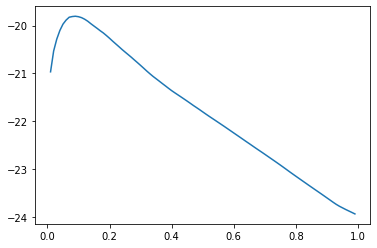

In [23]:
from sklearn.linear_model import Lasso

lm_l = Lasso()
np.mean(cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 4))

alpha = []
error = []
for i in range(1,100):
        alpha.append(i/100)
        lm_l = Lasso((i/100))
        error.append(np.mean(cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 4)))
        
plt.plot(alpha,error)

In [22]:
err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha', 'error'])
df_err[df_err.error == max(df_err.error) ]

,alpha,error
8,0.09,-19.805126


Hence an alpha of 0.09 is optimum 

In [30]:
lm_l = Lasso(alpha = 0.09)
lm_l.fit(X_train,y_train)

Lasso(alpha=0.09, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

#### Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

np.mean(cross_val_score(rf, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 4))

-13.341223622410581

Random Forest Regressor gives much better results

## 4. Model Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': range(10,300,10), 'criterion':('mse','mae'), 'max_features': ('auto','sqrt','log2')}
gs = GridSearchCV(rf, parameters, scoring = 'neg_mean_absolute_error', cv = 4)
gs.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [29]:
print(gs.best_score_,'\n',gs.best_estimator_)

-12.503806719315897 
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


## 5. Test Ensembles

In [32]:
tpred_lm = lm.predict(X_test)
tpred_lm_l = lm_l.predict(X_test)
tpred_rf= gs.best_estimator_.predict(X_test)

In [34]:
from sklearn.metrics import mean_absolute_error
print('Error for MLR: ',mean_absolute_error(y_test,tpred_lm)) 
print('Error for Lasso Regression: ',mean_absolute_error(y_test,tpred_lm_l))
print('Error for Random Forrest: ',mean_absolute_error(y_test,tpred_rf))      

Error for MLR:  20.776009111506774
Error for Lasso Regression:  20.87506514592337
Error for Random Forrest:  12.238633847897166


In [36]:
print('Error for a combination model: ',mean_absolute_error(y_test,((tpred_lm + tpred_rf)/2)))      

Error for a combination model:  15.822929028645044


## 6. Productionizing the Model

In [38]:
import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

In [40]:
file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(X_test.iloc[1,:].values.reshape(1,-1))


array([167.5])

A file "model_file.p" has been successfully created and seems to be working fine!